# Gymnasiumの環境構築

In [1]:
!poetry add gymnasium[all]

Using version ^0.29.1 for gymnasium

Updating dependencies
Resolving dependencies... (22.0s)://files.pythonhosted.org/packages/71/64/e7f0876716d5c35612bf8e9e49299d0f491285f10f36cbb481556ab0062b/moviepy-1.0.2.tar.gz  99% (13.0s)Resolving dependencies... (17.2s)Resolving dependencies... (18.0s)Resolving dependencies... (18.3s)

Package operations: 50 installs, 1 update, 0 removals

  - Downgrading decorator (5.1.1 -> 4.4.2): Pending...
  - Installing nvidia-nvjitlink-cu12 (12.5.82): Pending...
  - Installing nvidia-nvjitlink-cu12 (12.5.82): Pending...
  - Downgrading decorator (5.1.1 -> 4.4.2): Downloading... 0%
  - Installing nvidia-nvjitlink-cu12 (12.5.82): Pending...
  - Installing nvidia-nvjitlink-cu12 (12.5.82): Downloading... 0%
  - Installing nvidia-nvjitlink-cu12 (12.5.82): Downloading... 0%
  - Downgrading decorator (5.1.1 -> 4.4.2): Downloading... 100%
  - Installing nvidia-nvjitlink-cu12 (12.5.82): Downloading... 0%
  - Installing nvidia-nvjitlink-cu12 (12.5.82): Downloading..

In [2]:
import gymnasium as gym

# 月着陸(Lunar Lander)ゲームの環境を作成
env = gym.make("LunarLander-v2", render_mode="human")

# ゲーム環境を初期化
observation, info = env.reset()

# ゲームのステップを1000回プレイ
for _ in range(1000):
    # 環境からランダムな行動を取得
    # これがエージェントの行動になるので、本来はAIが行動を決定するべきところ
    action = env.action_space.sample()

    # 行動を実行すると、環境の状態が更新される
    observation, reward, terminated, truncated, info = env.step(action)

    # ゲームが終了したら、環境を初期化して再開
    if terminated or truncated:
        observation, info = env.reset()

env.close()

KeyboardInterrupt: 

In [8]:
import gymnasium as gym


env = gym.make("CartPole-v1")
observation, info = env.reset(seed=42)

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print(observation)

    if terminated or truncated:
        print("Episode finished after {} timesteps".format(t+1))

        observation, info = env.reset()
env.close()

[ 0.02727336  0.18847767  0.03625453 -0.26141977]
[ 0.03104291 -0.00714255  0.03102613  0.04247424]
[ 0.03090006 -0.20269535  0.03187562  0.3447825 ]
[ 0.02684616 -0.3982559   0.03877127  0.6473442 ]
[ 0.01888104 -0.20369498  0.05171815  0.36711797]
[ 0.01480714 -0.00934462  0.05906051  0.09118061]
[ 0.01462025  0.18488325  0.06088412 -0.18229952]
[ 0.01831791 -0.01105466  0.05723813  0.12895164]
[ 0.01809682  0.18320261  0.05981717 -0.14513826]
[ 0.02176087 -0.0127227   0.0569144   0.16579984]
[ 0.02150642  0.18154031  0.0602304  -0.10839905]
[ 0.02513722  0.37574977  0.05806242 -0.38148794]
[ 0.03265222  0.57000124  0.05043266 -0.65531343]
[ 0.04405224  0.37421477  0.03732639 -0.34718618]
[ 0.05153654  0.5687865   0.03038266 -0.627869  ]
[ 0.06291227  0.37325394  0.01782528 -0.32577446]
[ 0.07037735  0.5681176   0.0113098  -0.6127832 ]
[ 0.0817397   0.37283945 -0.00094587 -0.31655967]
[ 0.08919649  0.56797487 -0.00727706 -0.60954076]
[ 0.10055599  0.7631978  -0.01946788 -0.9045068 ]


In [12]:
# 値の確認
print(env.observation_space)
print(env.action_space)


Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Discrete(2)


# Q-Learningを実装する


In [18]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo

In [19]:
# Q-networkの定義
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [20]:

# ハイパーパラメータの設定
BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001
MEMORY_SIZE = 10000
UPDATE_TARGET_EVERY = 100

# 環境の作成
env = gym.make("LunarLander-v2", render_mode="rgb_array")


# 動画記録用の関数
def should_record_video(episode_id):
    return episode_id in [0, 499, 999]  # エピソード1, 500, 1000で記録

env = RecordVideo(env, video_folder="./videos", episode_trigger=should_record_video)

# 状態空間と行動空間のサイズを取得
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


/root/.cache/pypoetry/virtualenvs/gymnasium-tutorial-GGubfbDK-py3.10/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /kaggle/gymnasium_tutorial/notebook/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [21]:

# メインのQ-networkとターゲットQ-networkの初期化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
main_q_network = QNetwork(state_size, action_size).to(device)
target_q_network = QNetwork(state_size, action_size).to(device)
target_q_network.load_state_dict(main_q_network.state_dict())

cuda


<All keys matched successfully>

In [26]:

# オプティマイザの設定
optimizer = optim.Adam(main_q_network.parameters(), lr=LEARNING_RATE)

# リプレイメモリの初期化
memory = deque(maxlen=MEMORY_SIZE)

# エピソード数の設定
num_episodes = 1000

# εの初期化
epsilon = EPSILON_START

# 報酬の記録用リスト
li_rewards = []

In [27]:

# 学習ループ
for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    total_reward = 0
    done = False

    while not done:
        # ε-greedy方策で行動を選択
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = main_q_network(state).max(1)[1].item()

        # 行動を実行し、次の状態と報酬を取得
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        total_reward += reward

        # リプレイメモリに経験を保存
        memory.append((state, action, reward, next_state, done))

        # バッチ学習
        if len(memory) > BATCH_SIZE:
            batch = random.sample(memory, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.cat(states)
            actions = torch.LongTensor(actions).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.cat(next_states)
            dones = torch.FloatTensor(dones).to(device)

            # Q値の計算
            current_q_values = main_q_network(states).gather(1, actions.unsqueeze(1))
            next_q_values = target_q_network(next_states).max(1)[0].detach()
            target_q_values = rewards + (1 - dones) * GAMMA * next_q_values

            # 損失の計算と最適化
            loss = nn.MSELoss()(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        state = next_state

    # εの減衰
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    # ターゲットネットワークの更新
    if episode % UPDATE_TARGET_EVERY == 0:
        target_q_network.load_state_dict(main_q_network.state_dict())

    print(f"Episode {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")
    li_rewards.append(total_reward)

env.close()

Episode 1, Total Reward: -193.531103507779, Epsilon: 0.99
Episode 2, Total Reward: -352.5369500945461, Epsilon: 0.99
Episode 3, Total Reward: -132.31589518539005, Epsilon: 0.99
Episode 4, Total Reward: -142.8620997701567, Epsilon: 0.98
Episode 5, Total Reward: -121.85567597049985, Epsilon: 0.98
Episode 6, Total Reward: -284.42211544200717, Epsilon: 0.97
Episode 7, Total Reward: -80.20181533372005, Epsilon: 0.97
Episode 8, Total Reward: -435.7983077503071, Epsilon: 0.96
Episode 9, Total Reward: -93.10971294246181, Epsilon: 0.96
Episode 10, Total Reward: -78.80055047911121, Epsilon: 0.95
Episode 11, Total Reward: -123.03309546307966, Epsilon: 0.95
Episode 12, Total Reward: -293.47265494719954, Epsilon: 0.94
Episode 13, Total Reward: -186.51671573393295, Epsilon: 0.94
Episode 14, Total Reward: -343.4669331050583, Epsilon: 0.93
Episode 15, Total Reward: -12.508400275600323, Epsilon: 0.93
Episode 16, Total Reward: -68.9065592687009, Epsilon: 0.92
Episode 17, Total Reward: -96.77581906559325

Moviepy - Done !
Moviepy - video ready /kaggle/gymnasium_tutorial/notebook/videos/rl-video-episode-499.mp4
Episode 497, Total Reward: -143.9165126139613, Epsilon: 0.08
Episode 498, Total Reward: -174.1006819155173, Epsilon: 0.08
Episode 499, Total Reward: -10.608277347735154, Epsilon: 0.08
Episode 500, Total Reward: -72.29132161102015, Epsilon: 0.08
Episode 501, Total Reward: -46.567823826135196, Epsilon: 0.08
Episode 502, Total Reward: -56.00896969885313, Epsilon: 0.08
Episode 503, Total Reward: 92.84299935253757, Epsilon: 0.08
Episode 504, Total Reward: -18.937501470426113, Epsilon: 0.08
Episode 505, Total Reward: -98.84075159118106, Epsilon: 0.08
Episode 506, Total Reward: -111.5007285687673, Epsilon: 0.08
Episode 507, Total Reward: -120.22471018684361, Epsilon: 0.08
Episode 508, Total Reward: -48.27727768740762, Epsilon: 0.08
Episode 509, Total Reward: -31.293632677274985, Epsilon: 0.08
Episode 510, Total Reward: -61.58879114002825, Epsilon: 0.08
Episode 511, Total Reward: -171.092

Moviepy - Done !
Moviepy - video ready /kaggle/gymnasium_tutorial/notebook/videos/rl-video-episode-999.mp4
Episode 997, Total Reward: -301.71890978591296, Epsilon: 0.01
Episode 998, Total Reward: -197.95864548688553, Epsilon: 0.01
Episode 999, Total Reward: -212.65727546932519, Epsilon: 0.01
Episode 1000, Total Reward: -312.20297825557975, Epsilon: 0.01


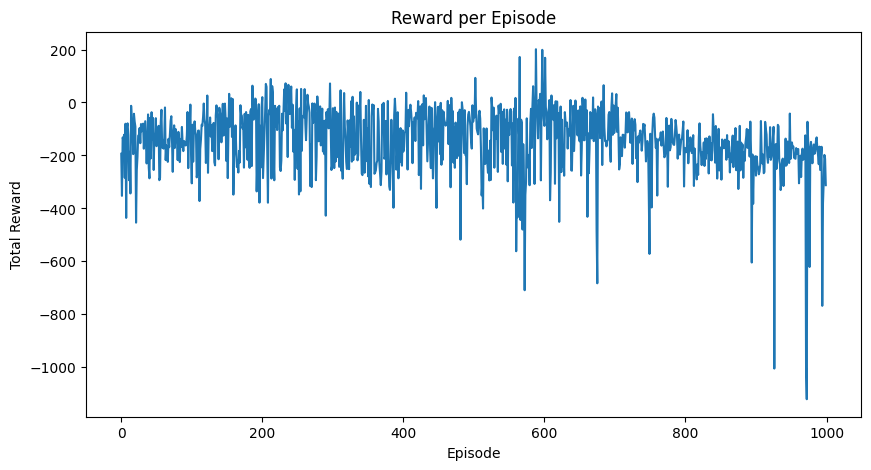

In [29]:

# 報酬の変化をグラフで表示
plt.figure(figsize=(10, 5))
plt.plot(li_rewards)
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.savefig('reward_plot.png')
plt.show()
print("動画は videos ディレクトリに保存されています。")


# Deep Q-Learningを実装

In [30]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo


In [31]:

# Deep Q-Networkの定義
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 経験リプレイバッファの定義
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# ハイパーパラメータの設定
BATCH_SIZE = 64
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001
MEMORY_SIZE = 10000
TARGET_UPDATE = 10

# 環境の作成
def make_env(episode):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    if episode in [0, 499, 999]:  # エピソード1, 500, 1000で記録
        env = RecordVideo(env, f"videos/episode_{episode+1}")
    return env

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# メインのDQNと目標DQNの初期化
env = gym.make("LunarLander-v2")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())

# オプティマイザとメモリの設定
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayBuffer(MEMORY_SIZE)

# εの初期化
epsilon = EPSILON_START

# 学習関数の定義
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = list(zip(*transitions))

    state_batch = torch.FloatTensor(batch[0]).to(device)
    action_batch = torch.LongTensor(batch[1]).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(batch[2]).unsqueeze(1).to(device)
    next_state_batch = torch.FloatTensor(batch[3]).to(device)
    done_batch = torch.FloatTensor(batch[4]).unsqueeze(1).to(device)

    q_values = policy_net(state_batch).gather(1, action_batch)
    next_q_values = target_net(next_state_batch).max(1)[0].unsqueeze(1)
    expected_q_values = reward_batch + GAMMA * next_q_values * (1 - done_batch)

    loss = nn.MSELoss()(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [32]:

# トレーニングループ
num_episodes = 1000
rewards = []

for episode in range(num_episodes):
    env = make_env(episode)
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).max(1)[1].item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        optimize_model()

    rewards.append(total_reward)
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode+1}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

env.close()


/tmp/ipykernel_77011/356099070.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  state_batch = torch.FloatTensor(batch[0]).to(device)


Moviepy - Building video /kaggle/gymnasium_tutorial/notebook/videos/episode_1/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/gymnasium_tutorial/notebook/videos/episode_1/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/gymnasium_tutorial/notebook/videos/episode_1/rl-video-episode-0.mp4
Episode 1, Total Reward: -116.64036354791577, Epsilon: 0.99
Episode 2, Total Reward: -351.3199884835515, Epsilon: 0.99
Episode 3, Total Reward: -169.15747373063707, Epsilon: 0.99
Episode 4, Total Reward: -122.82175792122996, Epsilon: 0.98
Episode 5, Total Reward: -360.7804285609261, Epsilon: 0.98
Episode 6, Total Reward: -225.98154741371206, Epsilon: 0.97
Episode 7, Total Reward: -98.84008149856406, Epsilon: 0.97
Episode 8, Total Reward: -443.87654859498815, Epsilon: 0.96
Episode 9, Total Reward: -289.6687320285728, Epsilon: 0.96
Episode 10, Total Reward: -125.94772292618308, Epsilon: 0.95
Episode 11, Total Reward: -149.89755509366574, Epsilon: 0.95
Episode 12, Total Reward: -92.96071045010525, Epsilon: 0.94
Episode 13, Total Reward: -13.962421627720246, Epsilon: 0.94
Episode 14, Total Reward: -130.0881318691415, Epsilon: 0.93
Episode 15, Total Reward: -147.173609226064, E

Moviepy - Done !
Moviepy - video ready /kaggle/gymnasium_tutorial/notebook/videos/episode_500/rl-video-episode-0.mp4
Episode 500, Total Reward: 224.7229261712297, Epsilon: 0.08
Episode 501, Total Reward: 188.5843583788432, Epsilon: 0.08
Episode 502, Total Reward: 239.67631794555774, Epsilon: 0.08
Episode 503, Total Reward: 212.01109357700705, Epsilon: 0.08
Episode 504, Total Reward: 205.30610266653477, Epsilon: 0.08
Episode 505, Total Reward: 254.77215429135714, Epsilon: 0.08
Episode 506, Total Reward: 225.14621092967315, Epsilon: 0.08
Episode 507, Total Reward: 282.29339117962644, Epsilon: 0.08
Episode 508, Total Reward: 206.56778631026572, Epsilon: 0.08
Episode 509, Total Reward: 232.40912820808643, Epsilon: 0.08
Episode 510, Total Reward: 244.0252663601313, Epsilon: 0.08
Episode 511, Total Reward: 215.4176045115261, Epsilon: 0.08
Episode 512, Total Reward: 203.21072251953953, Epsilon: 0.08
Episode 513, Total Reward: 239.43009106396073, Epsilon: 0.08
Episode 514, Total Reward: 1.1021

Moviepy - Done !
Moviepy - video ready /kaggle/gymnasium_tutorial/notebook/videos/episode_1000/rl-video-episode-0.mp4
Episode 1000, Total Reward: -45.91575468667699, Epsilon: 0.01


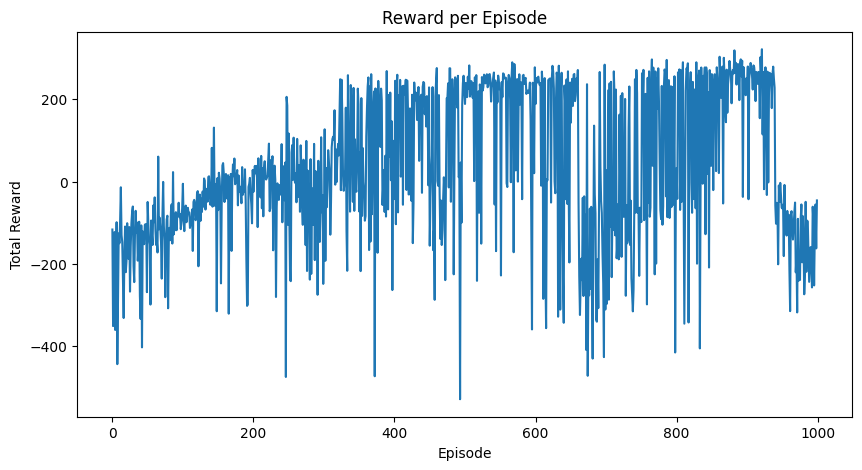

動画は videos ディレクトリに保存されています。


In [33]:

# 報酬の推移をプロット
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.savefig('reward_plot.png')
plt.show()

print("動画は videos ディレクトリに保存されています。")